## 1. Module import, data input and cleaning 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import random
from numpy import *
import time

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pwd

'C:\\Users\\akshi\\Downloads\\ADS'

In [3]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 5EA2-B96D

 Directory of C:\Users\akshi\Downloads\ADS

07/05/2023  06:52 PM    <DIR>          .
07/05/2023  05:09 PM    <DIR>          ..
07/05/2023  06:51 PM    <DIR>          .ipynb_checkpoints
07/05/2023  06:52 PM            36,935 INFO7390_Assignment 1_Akshita_Barot.ipynb
07/05/2023  06:51 PM         3,002,388 K Means basics-1.ipynb
07/04/2023  11:25 PM        23,715,248 Online Retail-1.xlsx
               3 File(s)     26,754,571 bytes
               3 Dir(s)  89,603,239,936 bytes free


### Read the data

In [4]:
df = pd.read_excel("Online Retail-1.xlsx")
print(df.shape)
df.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<AxesSubplot:xlabel='Percent missing', ylabel='Feature'>

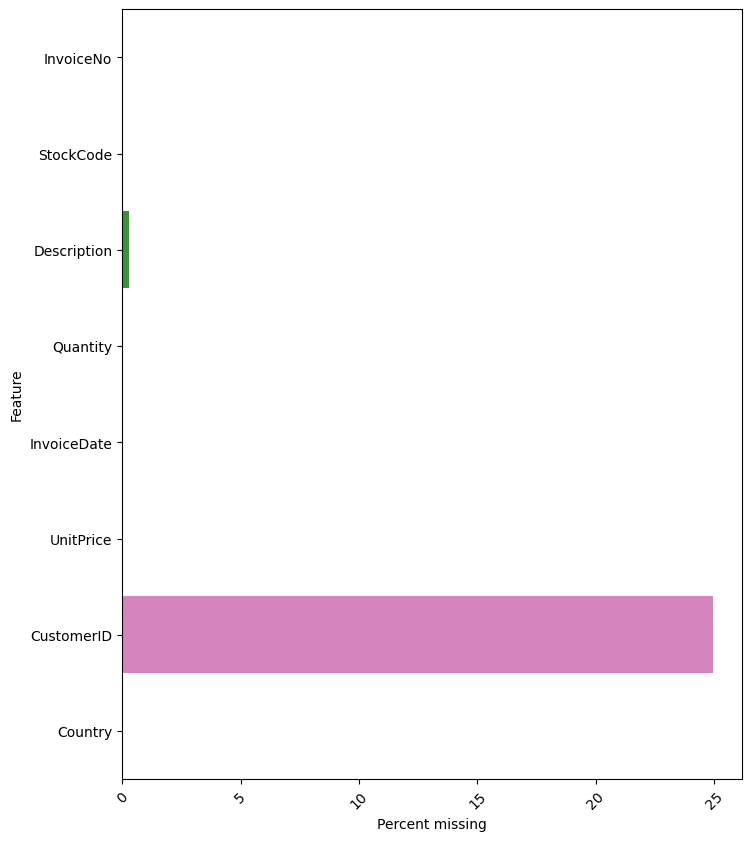

In [6]:
## Calculate the percentage null values for each column or feature

null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature", "Percent missing"]
plt.figure(figsize =  (8,10))
plt.xticks(rotation = 45)
sns.barplot(x = "Percent missing", y = "Feature", data = null_vals, orient = "h")

In [7]:
## Drop rows with any null values

df1 = df.dropna(subset = ["CustomerID","Description"])
df1.shape

(406829, 8)

In [8]:
## Drop duplicated rows

df2 = df1.drop_duplicates()
print(df2.shape)
df2.head(2)

(401604, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
## Select only columns we need

df3 = df2[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']]
print(df3.shape)
df3.head(2)

(401604, 5)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39


#### Feature Engineering

In [10]:
## Create a total price column by multipliying quantity with unit price

df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']
print(df3.shape)
df3.head(2)

(401604, 6)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [11]:
## Print out earliest and latest date in the data

print('Min:{}; Max:{}'.format(df3["InvoiceDate"].min(),df3["InvoiceDate"].max()))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [12]:
## Create a reference point for the analysis

current_date = dt.datetime(2011,12,10)
current_date

datetime.datetime(2011, 12, 10, 0, 0)

In [13]:
## Calculate the aggregates recency, frequency and monetary.
## Recently tells you how many days since last transaction for each customer, frequency tells you how frequently does a customer
# shop and, monetary tells you the total shipping spending for each customer

df4 = df3.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (current_date -x.max()).days, 'InvoiceNo': 'count',
                                                                'TotalPrice':'sum'})
df4.rename(columns = {'InvoiceDate':'Recency', 'InvoiceNo':'Frequency','TotalPrice':'Monetary'}, inplace = True)
print(df4.shape)
df4.head(3)

(4372, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24


In [14]:
## Remove rows with any zero values. This is to facilitate downstream pre-processing and avoid NaNs

df5 = df4[(df4 > 0).all(1)]
print(df5.shape)

(4284, 3)


## 2. Data Pre-processing

In [15]:
## The K-means clustering algorithm has a few assumptions about the data : 1. Data is not skewed 2. Features have the same mean
# 3. Feature have the same variance

df5.describe()

,Recency,Frequency,Monetary
count,4284.000000,4284.000000,4.284000e+03
mean,90.673436,90.187675,1.802891e+03
std,99.212825,217.749044,7.226246e+03
min,1.000000,1.000000,1.776357e-15
25%,17.000000,18.000000,2.988725e+02
50%,50.000000,42.000000,6.467200e+02
75%,140.000000,99.000000,1.596963e+03
max,373.000000,7812.000000,2.794890e+05


Looks like the mean and the standard deviations are so different. So we need to transform the data to meet the requirements

<AxesSubplot:xlabel='Recency', ylabel='Density'>

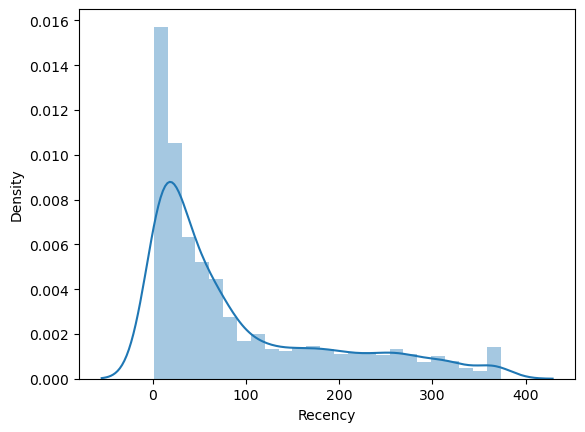

In [16]:
## Are the data dimensions skewed?

sns.distplot(df5['Recency'])

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

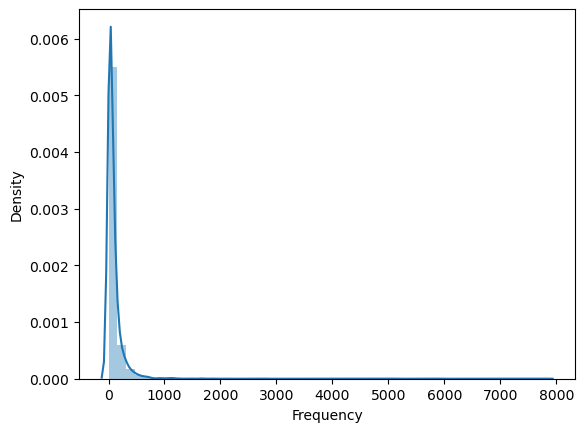

In [17]:
sns.distplot(df5['Frequency'])

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

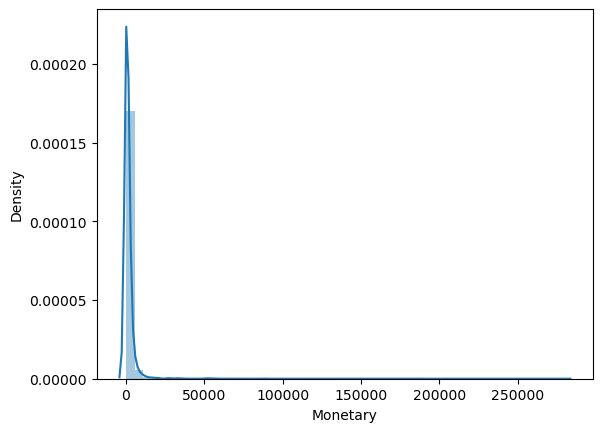

In [18]:
sns.distplot(df5['Monetary'])

In [19]:
## Looks like the data is skewed. Maybe monetary is not, but the other two definitely are skewed. We log 
## transform the data to remove the skew. Add a constant to offset any negative values

df6 =(np.log(df5 + 1))
print(df6.shape)
df6.head(3)

(4284, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1.098612,5.209486,8.368925
12348.0,4.330733,3.465736,7.494564
12349.0,2.944439,4.304065,7.472245


<AxesSubplot:xlabel='Recency', ylabel='Density'>

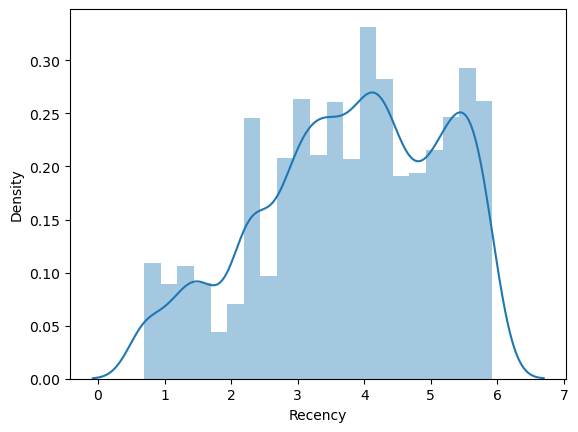

In [20]:
sns.distplot(df6['Recency'])

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

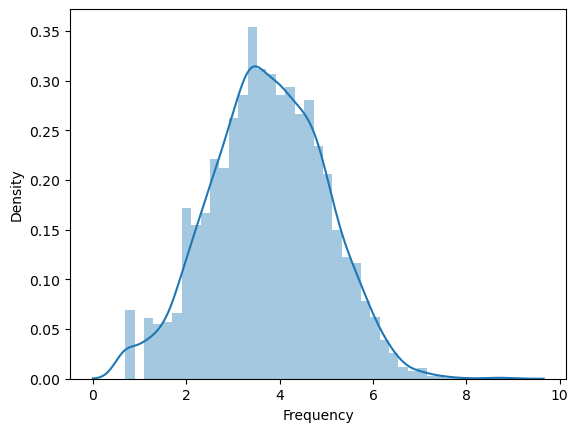

In [21]:
sns.distplot(df6['Frequency'])

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

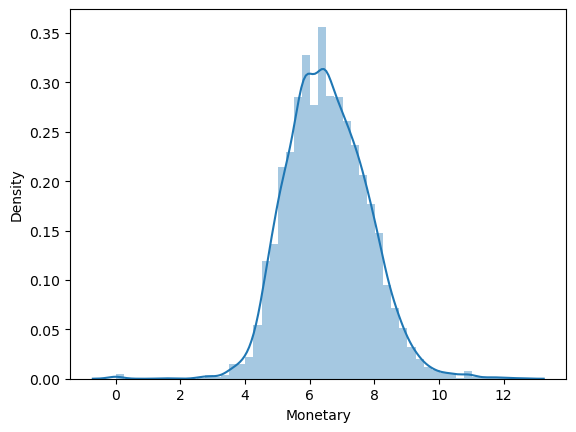

In [22]:
sns.distplot(df6['Monetary'])

The log has made the data look more normal

In [23]:
## Do scaling to make sure all dimensions have equal mean and variance

scaler = StandardScaler()
scaler.fit(df6)
df7 = pd.DataFrame(scaler.transform(df6))
df7.columns = df6.columns
df7.describe()

,Recency,Frequency,Monetary
count,4.284000e+03,4.284000e+03,4.284000e+03
mean,2.107462e-16,-2.522622e-16,-9.511014e-17
std,1.000117e+00,1.000117e+00,1.000117e+00
min,-2.257018e+00,-2.483190e+00,-5.244693e+00
25%,-6.530189e-01,-6.529482e-01,-6.740816e-01
50%,1.072545e-01,1.105753e-02,-5.693016e-02
75%,8.496283e-01,6.971834e-01,6.667453e-01
max,1.561752e+00,4.240429e+00,4.805312e+00


## 3. K-means Clustering

In [24]:
## Calculate the Euclidean distance between two vectors

def euclidean_distance(vector1, vector2):
    return np.sqrt(np.sum(np.power(vector2 - vector1, 2)))

## Initialize centroids with random samples
def initialize_centroids(data_set,k):
    num_samples, dim = data_set.shape
    centroids = zeros((k, dim))
    for i in range(k):
        index = int(random.uniform(0,num_samples))
        centroids[i,:] = data_set[index, :]
    return centroids

## K-means clustering algorithm
def kmeans_clustering(data_set, k):
    num_samples = data_set.shape[0]
    ## Create cluster assignment matrix
    cluster_assignments = mat(zeros((num_samples,2)))
    cluster_changed = True
    
    ## Step 1 - Initialize the centroids
    centroids = initialize_centroids(data_set,k)
    
    while cluster_changed:
        cluster_changed = False
        ## For each sample
        for i in range(num_samples):
            min_dist = 100000.0
            min_index = 0
            ## For each centroid
            ## Step 2 - Find the centroid closest to the sample
            for j in range(k):
                distance = euclidean_distance(centroids[j,:], data_set[i,:])
                if distance < min_dist:
                    min_dist = distance
                    min_index = j
                    
            ## Step 3 - Update the cluster assignment
            if cluster_assignments[i,0] != min_index:
                cluster_changed = True
                cluster_assignments[i,:] = min_index, min_dist**2
        
        ## Step 4 - Update centroids
        for j in range(k):
            points_in_cluster = data_set[nonzero(cluster_assignments[:,0].A ==j)[0]]
            centroids[j,:] = mean(points_in_cluster, axis =0)
            
    print('Cluster completed')
    return centroids, cluster_assignments

## Visualize the cluster - only 2D data will be available
def visualize_cluster(data_set,k, centroids, cluster_assignments):
    num_samples, dim = data_set.shape
    if dim != 2:
        print('Visualization cannot be done because it is not 2D')
        return 1
    
    marks = ['ro','og','ob','ko','^r','sr','dr','<r','+r','pr']
    if k> len(marks):
        print('k is too large')
        return 1
    
    # draw all the samples
    for i in range(num_samples):
        mark_index = int(cluster_assignments[i,0])
        plt.plot(data_set[i,0], data_set[i,1], marks[mark_index])
        
    
    marks = ['Dr','Dg','Db','Dk','^b','sb','db','<b','+b','pb']
    # draw the centroids
    for i in range(k):
        plt.plot(centroids[i,0], centroids[i,1], marks[i], markersize = 5)
        plt.xlabel('Frequency')
        plt.ylabel('Monetary')
        plt.title(f'k-means Clustering visualization (k = {k})')
    
    plt.show()

In [25]:
df8 = pd.DataFrame(df7, columns = ['Frequency', 'Monetary'])
print(df8)
df8 = mat(df8)

      Frequency  Monetary
0      1.188477  1.462077
1     -0.229147  0.761373
2      0.452393  0.743487
3     -0.696903 -0.584353
4      0.663996  0.640466
...         ...       ...
4279  -1.097274 -1.076019
4280  -1.356169 -1.714955
4281  -0.901216 -1.093868
4282   2.304316  0.865023
4283   0.418748  0.779021

[4284 rows x 2 columns]


Cluster completed


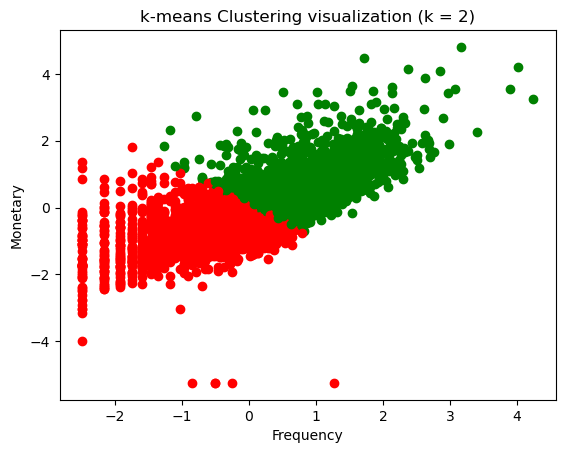

In [26]:
## clustering
## define k-value

k = 2
centroids, cluster_assignments = kmeans_clustering(df8,k)
## visualize the result
visualize_cluster(df8,k,centroids,cluster_assignments)

Cluster completed


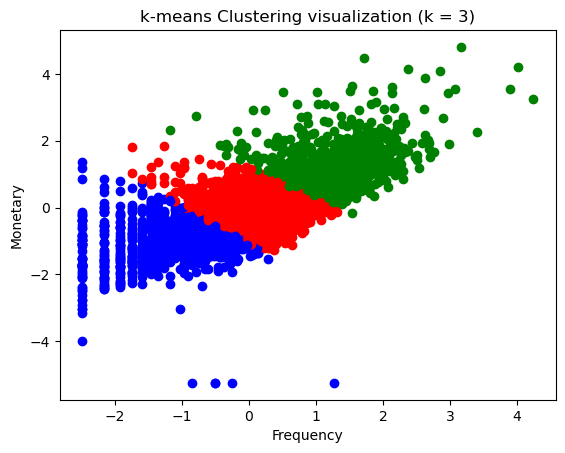

In [27]:
## clustering
## define k-value

k = 3
centroids, cluster_assignments = kmeans_clustering(df8,k)
## visualize the result
visualize_cluster(df8,k,centroids,cluster_assignments)

Cluster completed


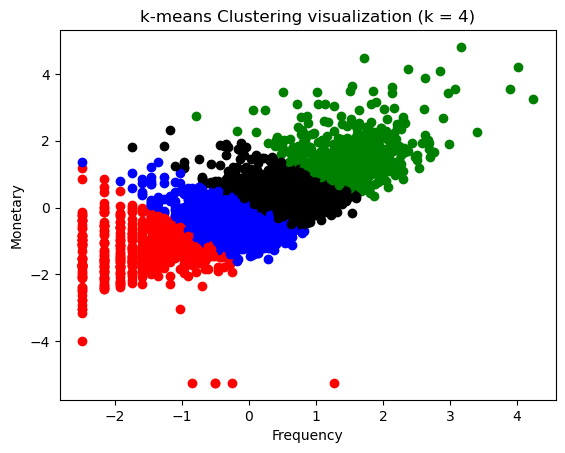

In [28]:
## clustering
## define k-value

k = 4
centroids, cluster_assignments = kmeans_clustering(df8,k)
## visualize the result
visualize_cluster(df8,k,centroids,cluster_assignments)

Cluster completed


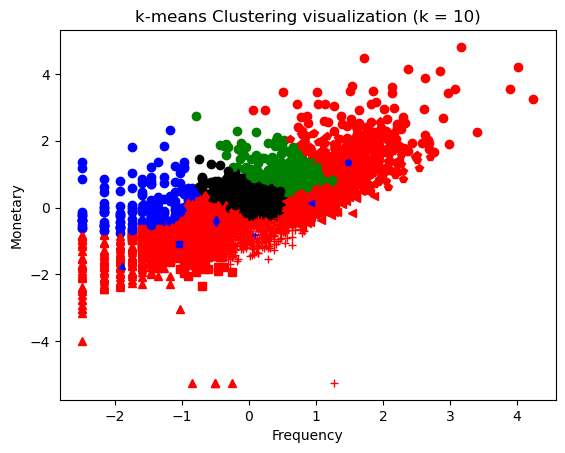

In [29]:
## clustering
## define k-value

k = 10
centroids, cluster_assignments = kmeans_clustering(df8,k)
## visualize the result
visualize_cluster(df8,k,centroids,cluster_assignments)

In [30]:
## clustering
## define k-value

k = 12
centroids, cluster_assignments = kmeans_clustering(df8,k)
## visualize the result
visualize_cluster(df8,k,centroids,cluster_assignments)

Cluster completed
k is too large


1

### Elbow Method

In [31]:
# Fit KMeans and calculate SSE for each *k*
ss_error = {}
for k in range(1, 20):
    k_means = KMeans(n_clusters=k, random_state=1)
    k_means.fit(df7)
    ss_error[k] = k_means.inertia_

<AxesSubplot:title={'center':'Elbow plot'}, xlabel='Value of k', ylabel='Sum of squared error'>

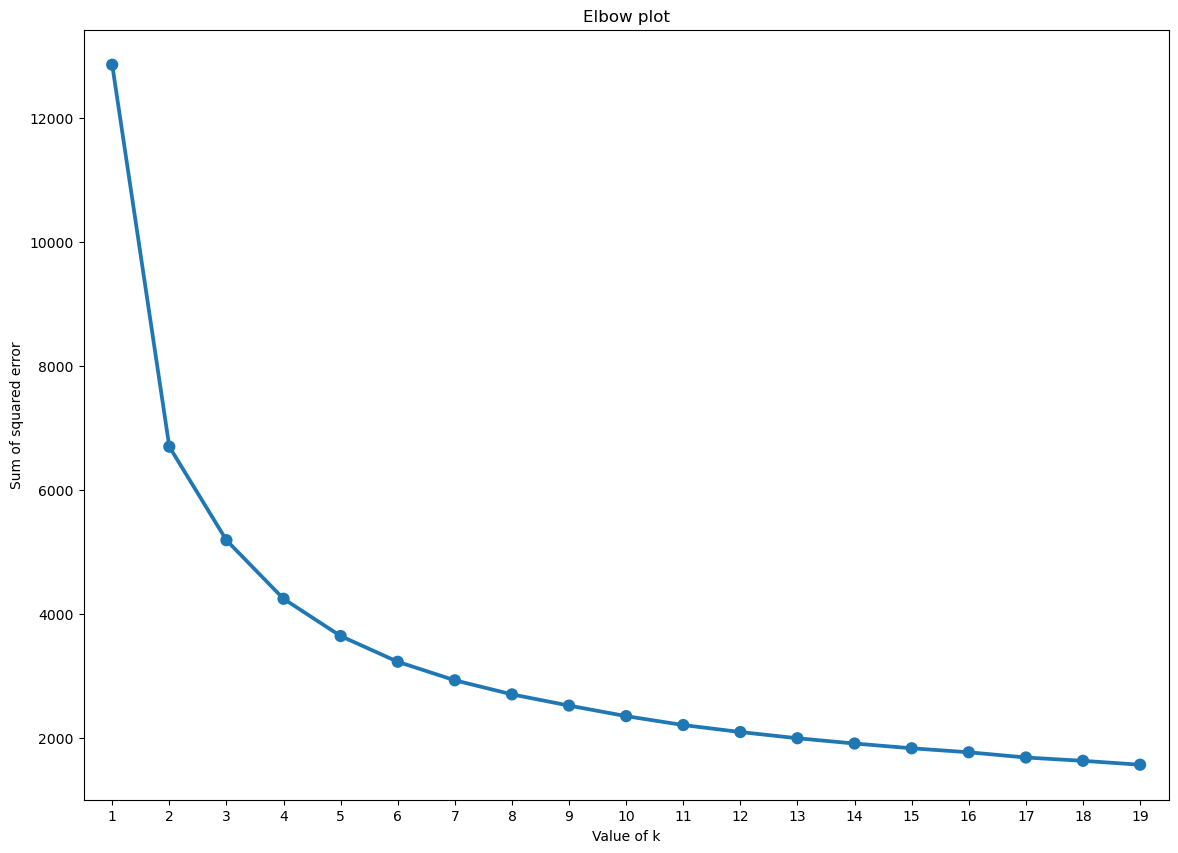

In [32]:
# Make elbow plot
plt.figure(figsize = (14,10))
plt.title('Elbow plot')
plt.xlabel('Value of k')
plt.ylabel('Sum of squared error')
sns.pointplot(x=list(ss_error.keys()), y=list(ss_error.values()))

### Silhoutte Method

For n_clusters = 2 The average silhouette_score is : 0.39940052469754456
For n_clusters = 3 The average silhouette_score is : 0.30424918497077985
For n_clusters = 4 The average silhouette_score is : 0.31159199306065416
For n_clusters = 5 The average silhouette_score is : 0.27791843412502665
For n_clusters = 6 The average silhouette_score is : 0.2739307222140703
For n_clusters = 7 The average silhouette_score is : 0.2647485192288998
For n_clusters = 8 The average silhouette_score is : 0.25970518979290436
For n_clusters = 10 The average silhouette_score is : 0.2607870612500416
For n_clusters = 12 The average silhouette_score is : 0.26568587996170023
For n_clusters = 14 The average silhouette_score is : 0.25744558813751117


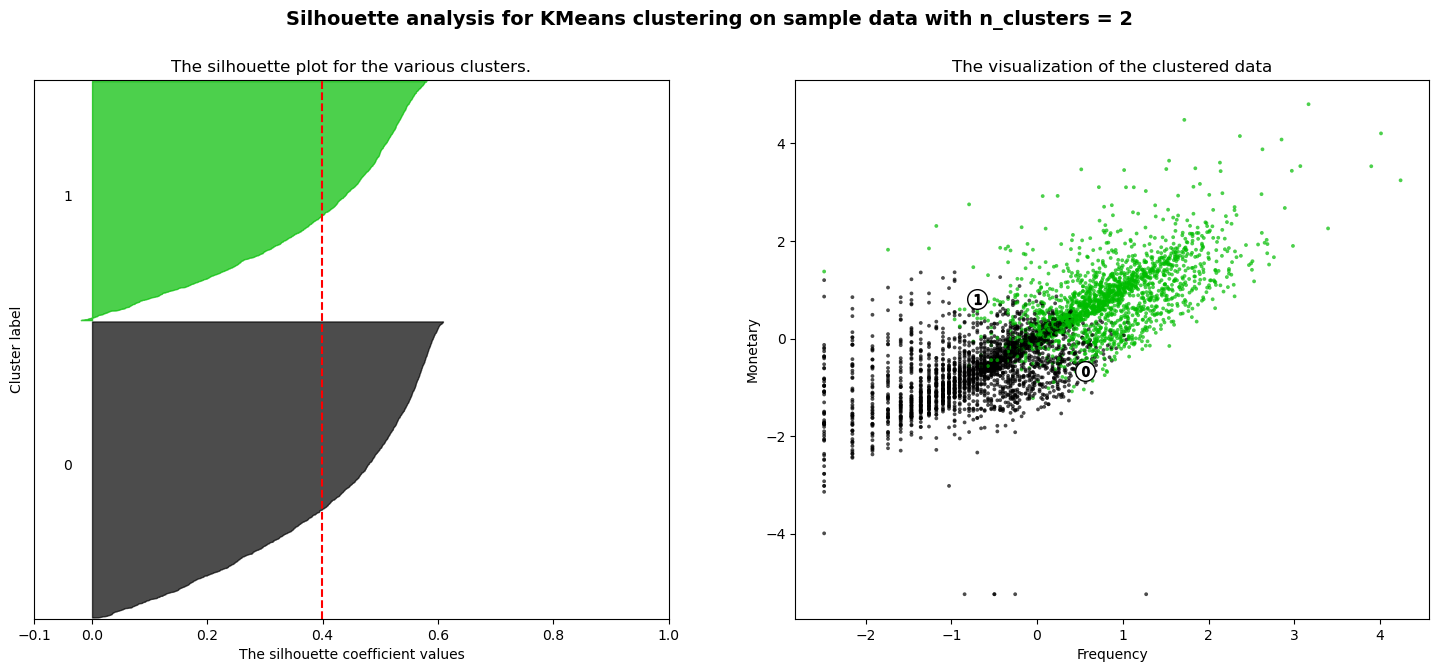

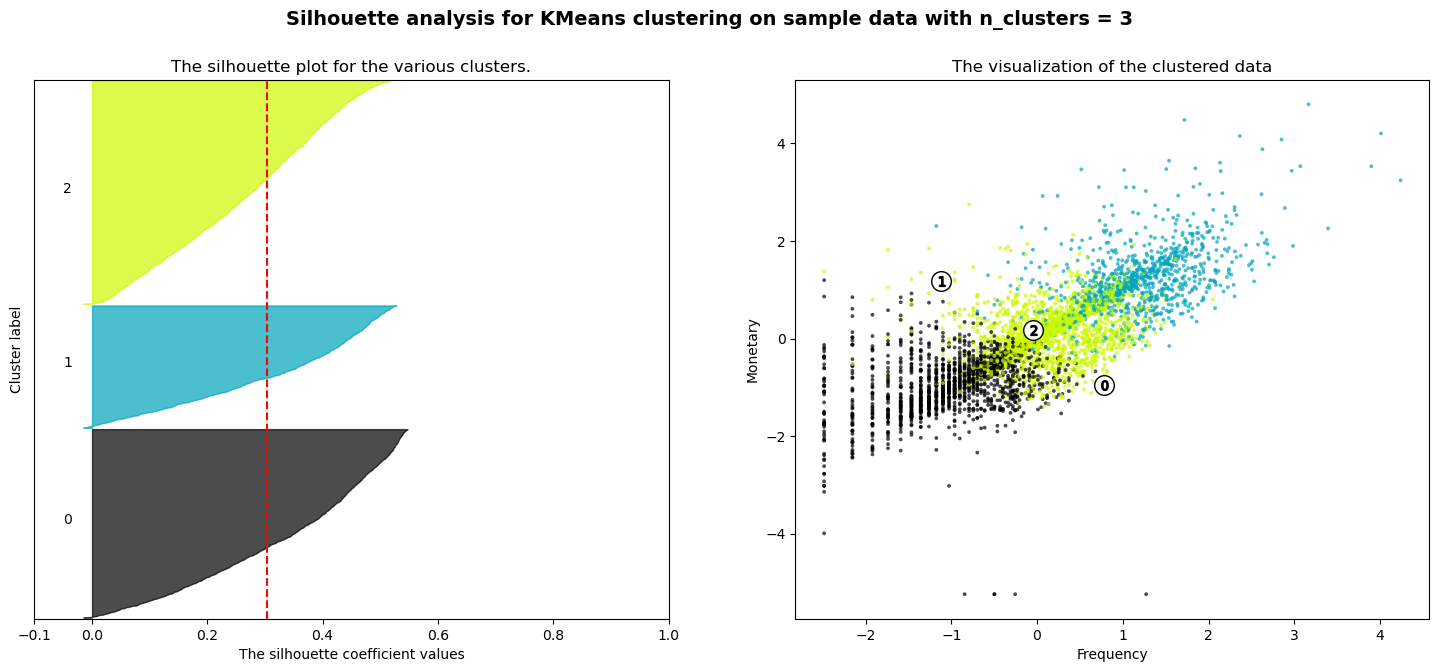

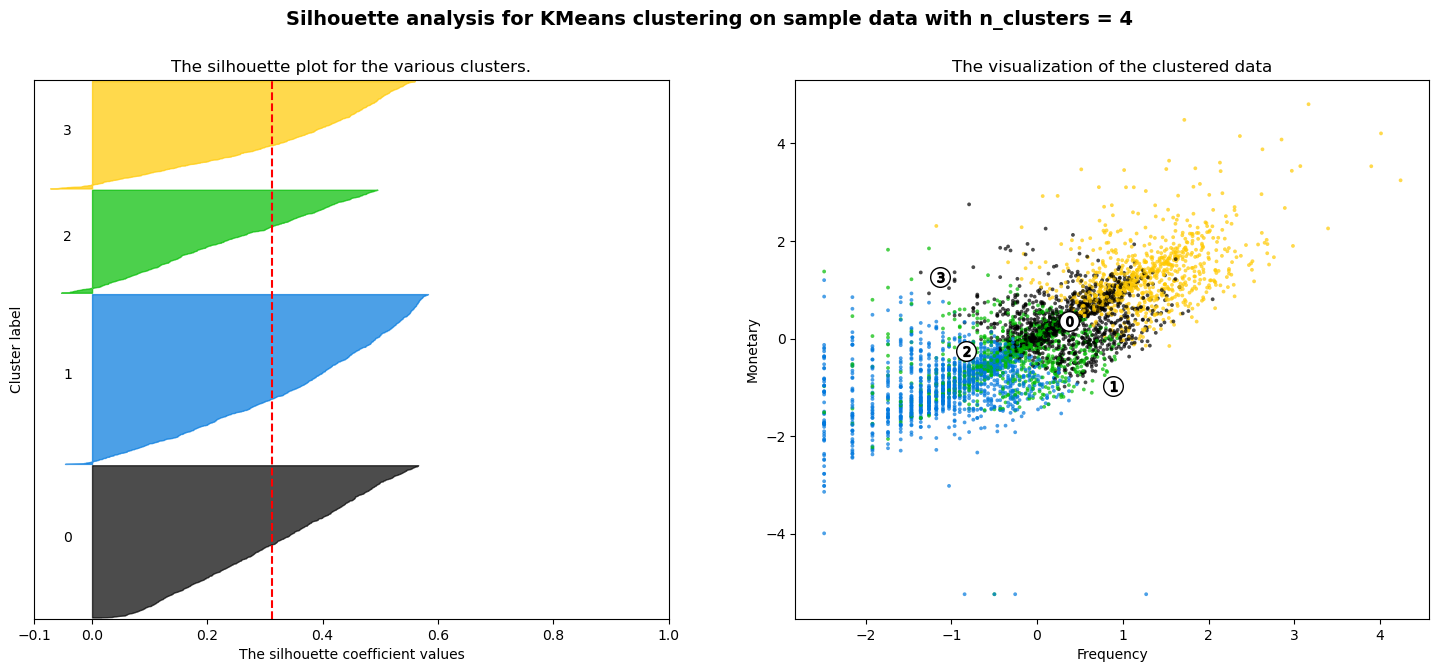

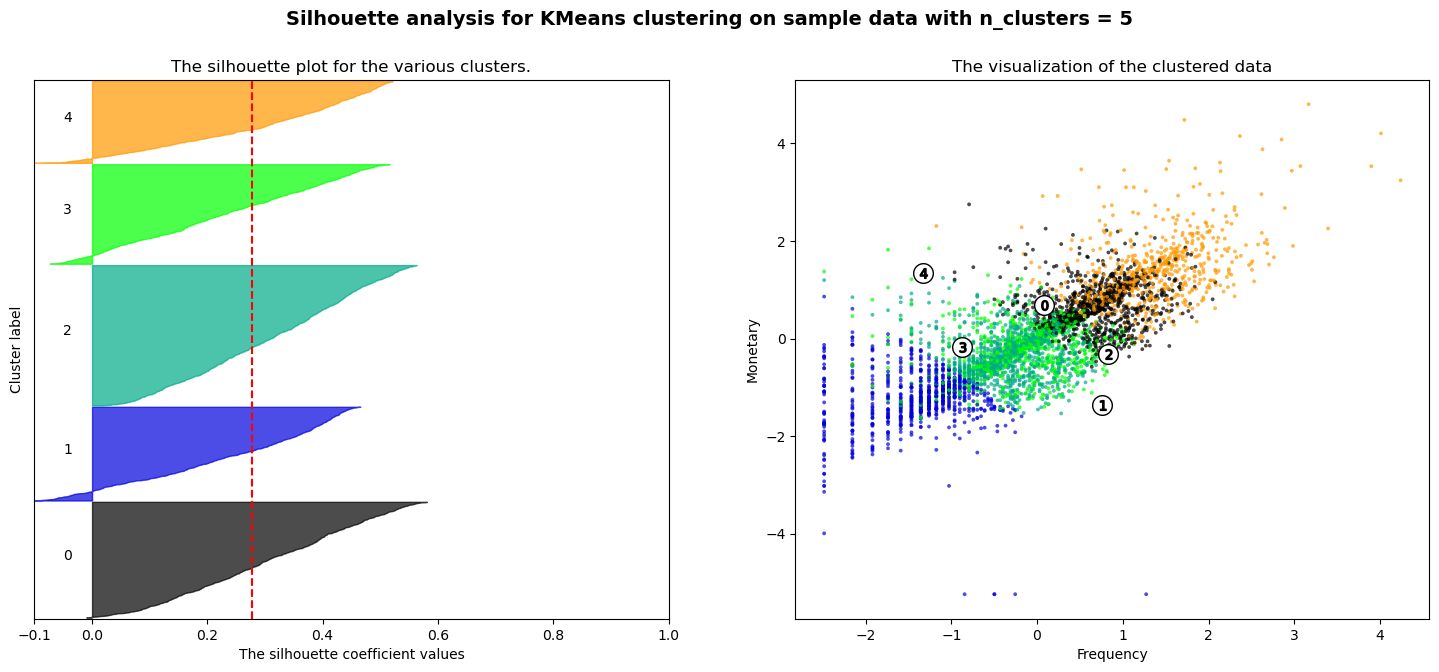

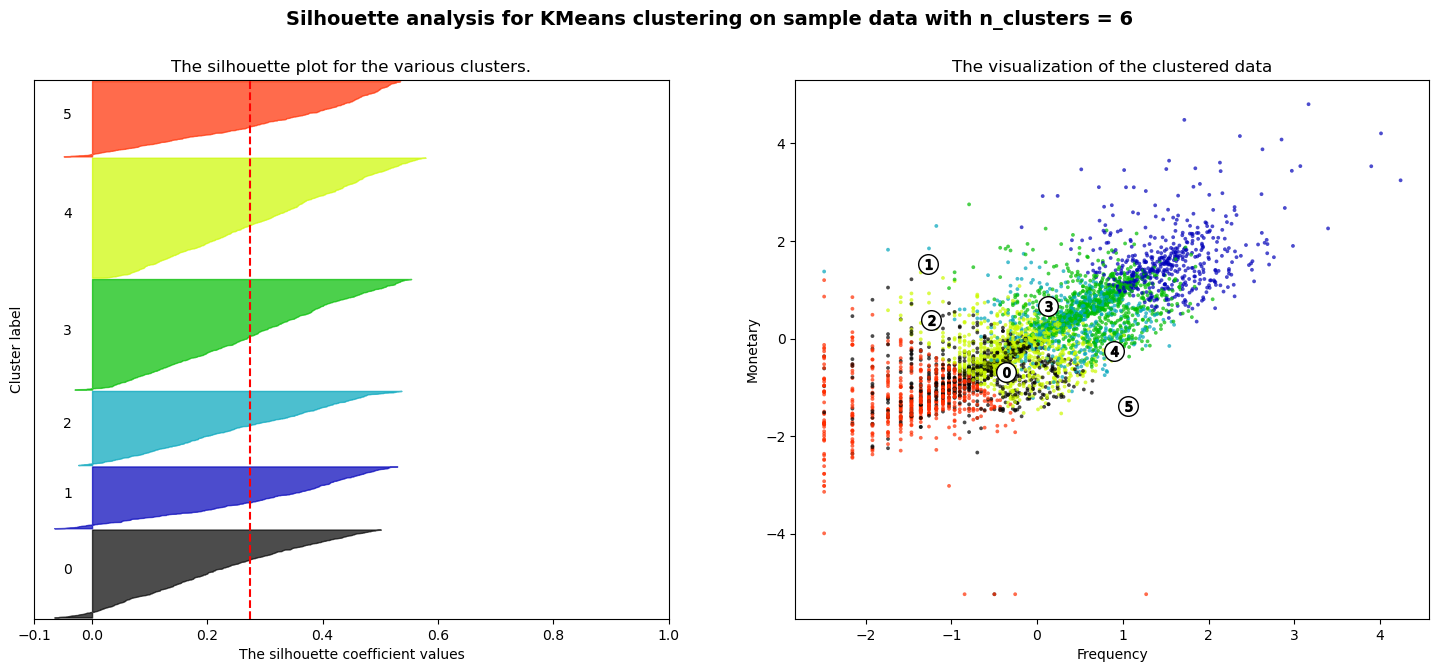

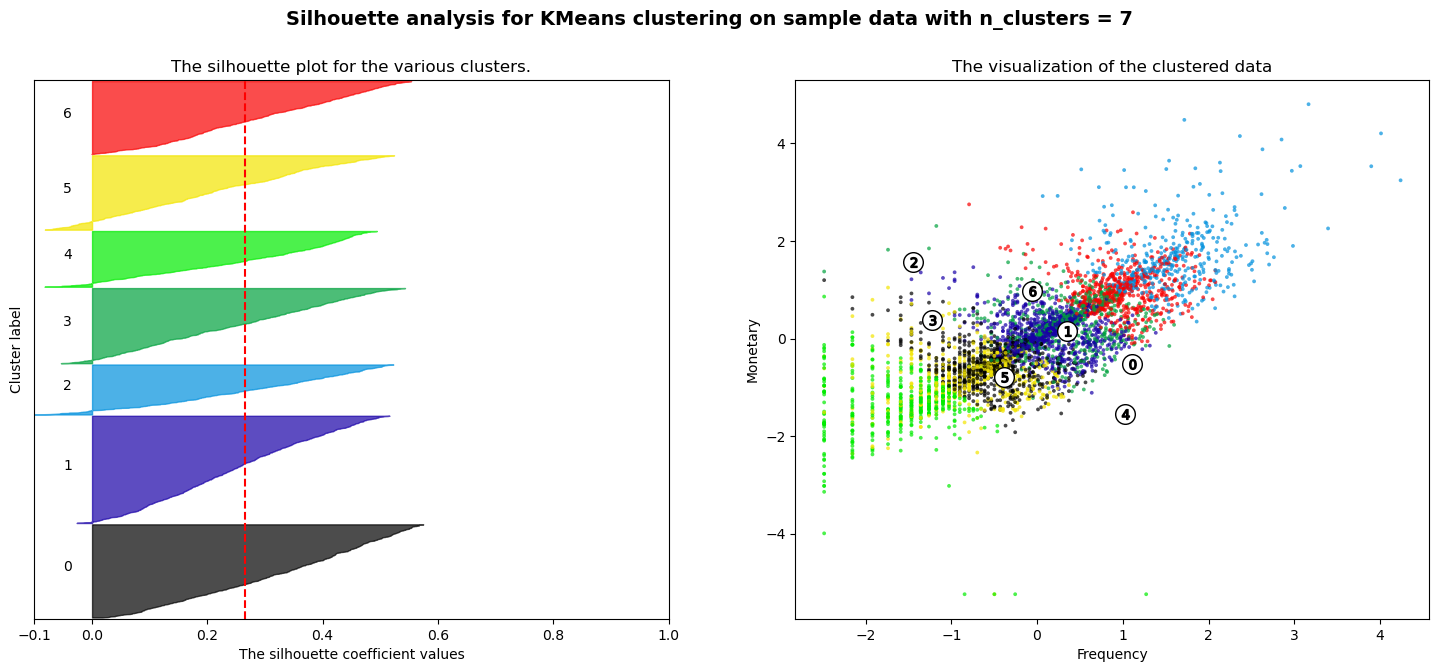

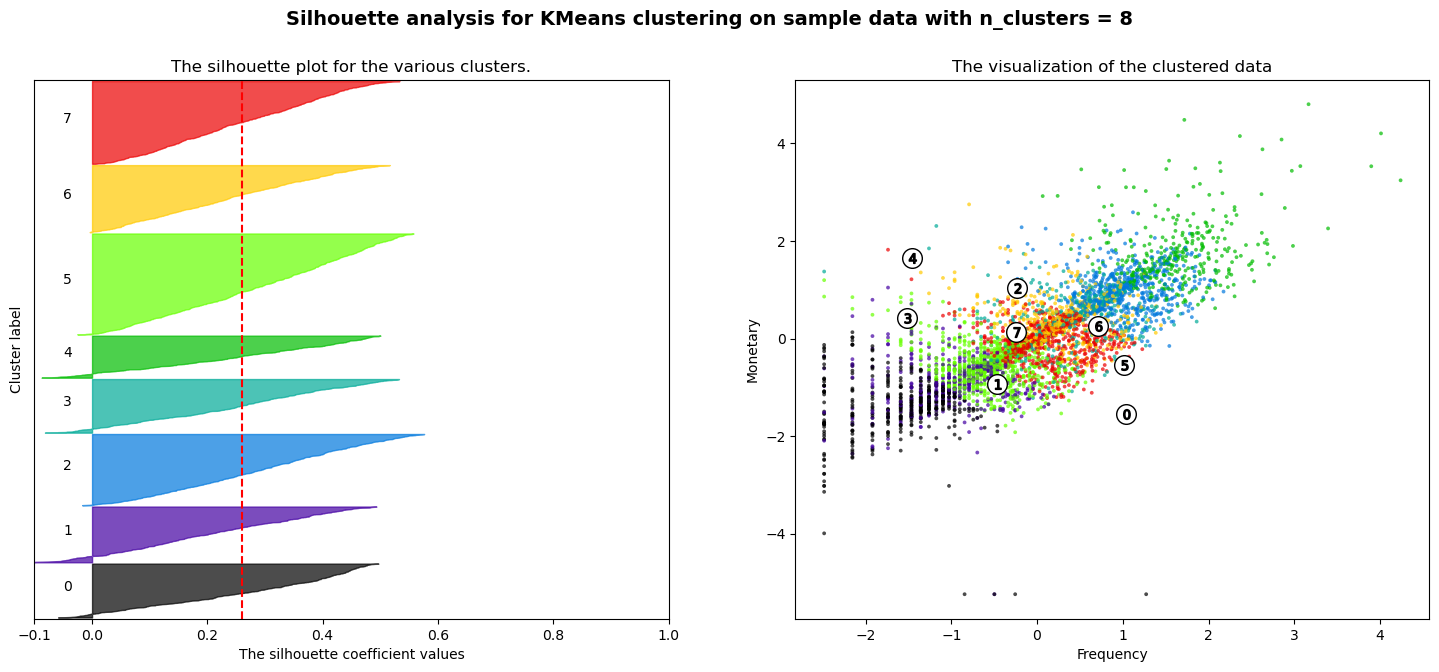

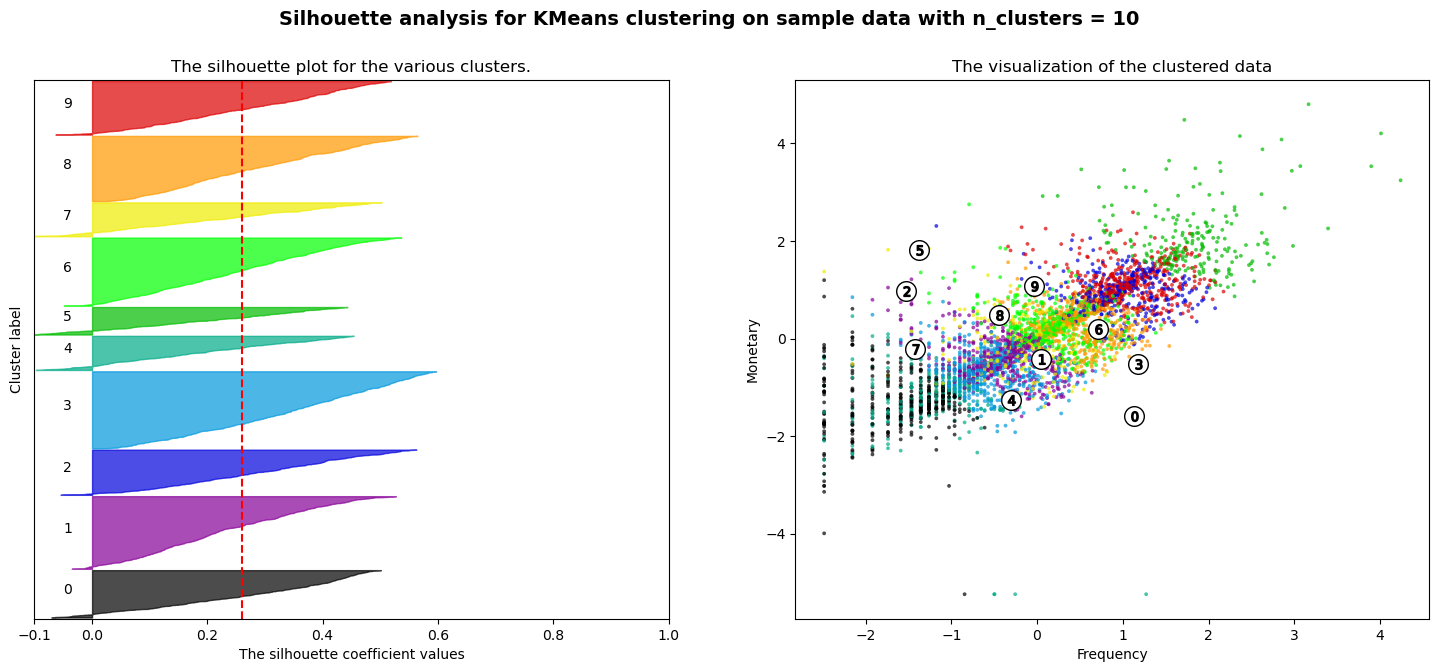

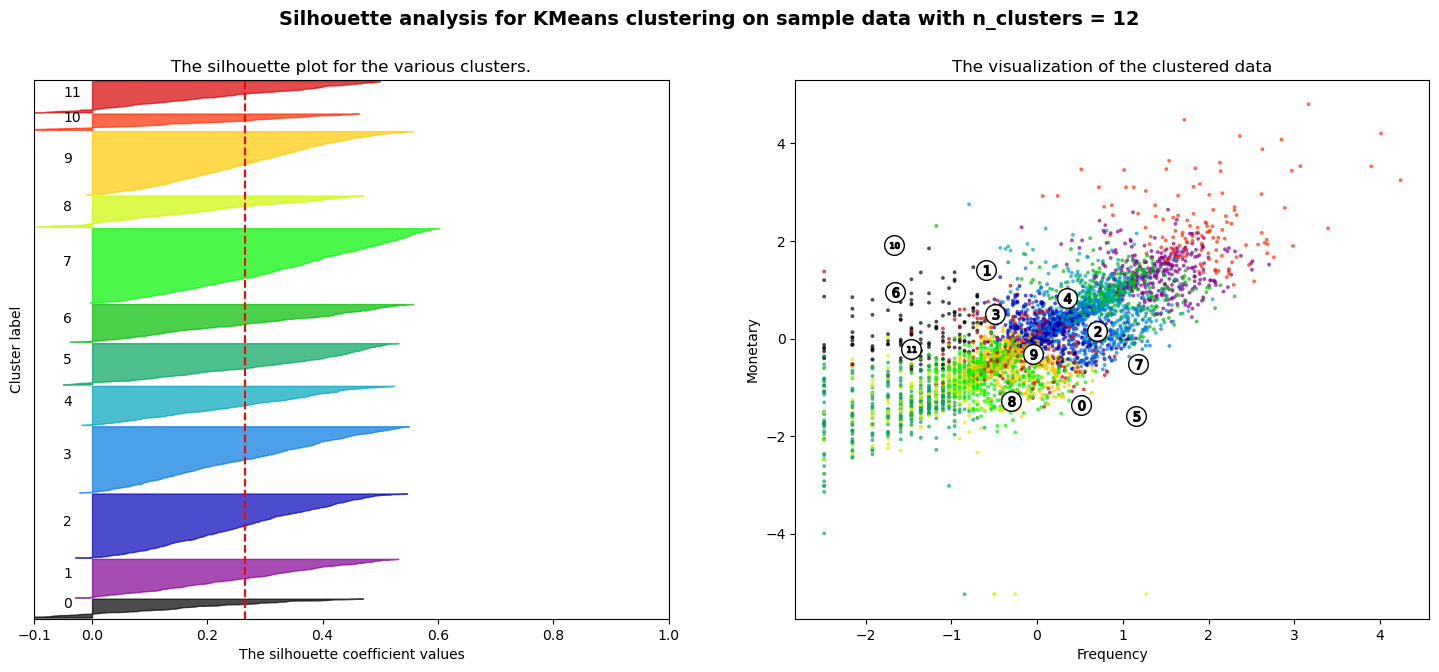

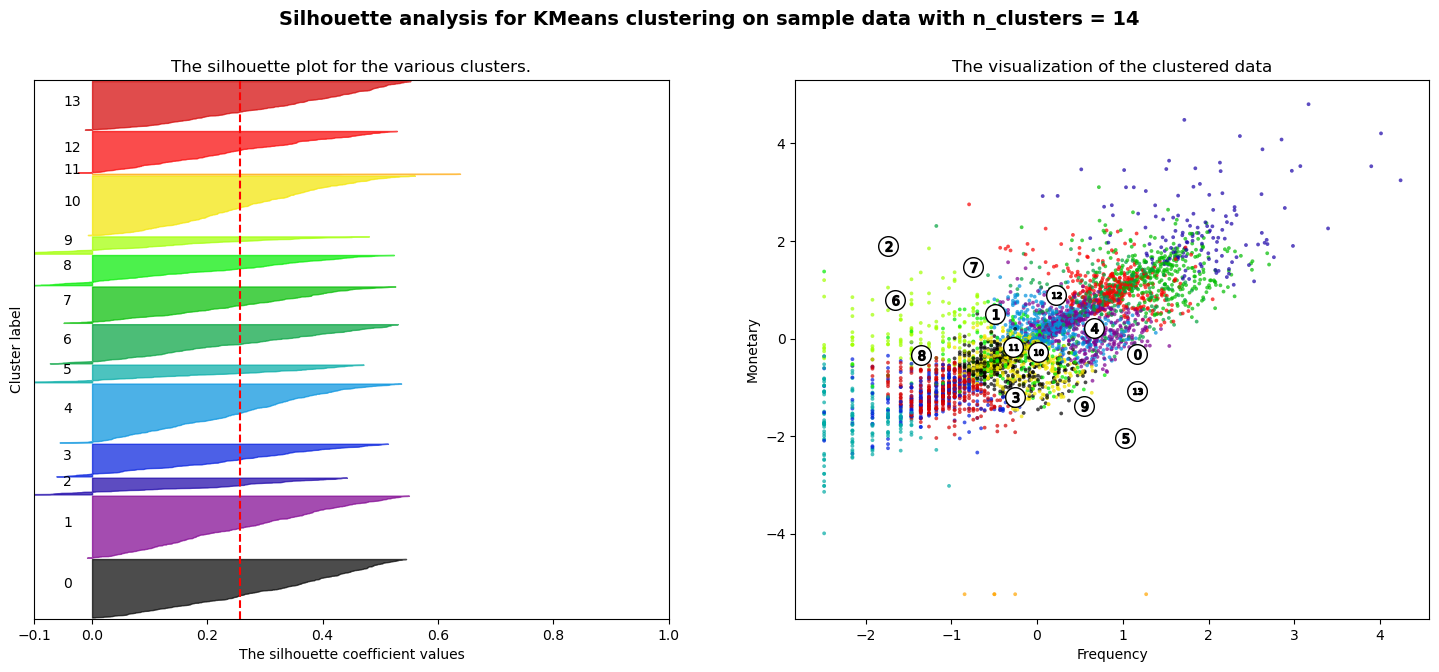

In [33]:
# Looks like k = 2 is a good solution. But always, explore other values of K around the elbow.
# Finally disucss several solutions with stakeholders to see which makes most sense !
# Here, we also use Silhoutte plots and scores

# Number of clusters confirmation by silhoutte scores
X = df7
range_n_clusters = [2, 3, 4, 5, 6,7,8,10,12,14]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X["Frequency"], X["Monetary"], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Monetary")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')



In [34]:
k_means = KMeans(n_clusters=2, random_state=1)
# Let's see how this works:
# Apply k-means on the preprocessed data and get cluster labels for each row

k_means.fit(df7)
clus_labels = k_means.labels_

In [35]:
# Get cluster characteristics. Since we are interested in the original values,
# we use the non-log transformed, non-standardized dataframe

df5_clus2 = df5.assign(Cluster = clus_labels)
print(df5_clus2.shape)
df5_clus2.head(2)

(4284, 4)


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,1


In [36]:
df5_clus2.groupby(['Cluster']).agg({ 'Recency': 'mean',
'Frequency': 'mean',
'Monetary': ['mean', 'count'],
}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          30.0     171.0   3521.0  1905
1         139.0      25.0    427.0  2379

In [37]:
# Looks like k = 2 has the best Silhoutte score. So let's pick k = 2 and do some interesting visualizations.
# Add cluster column to the pre-processed data

df8 = df7.assign(Cluster = clus_labels)
print(df8.shape)
df8.head(3)

(4284, 4)


,Recency,Frequency,Monetary,Cluster
0,-1.961024,1.188477,1.462077,0
1,0.398462,-0.229147,0.761373,1
2,-0.613549,0.452393,0.743487,0


In [38]:
# Use melt to transform the dataframe (not the data itself)

df8_melt = pd.melt(df8.reset_index(), id_vars=['Cluster'],
value_vars=['Recency', 'Frequency', 'Monetary'], var_name='Attribute',
value_name='Value')

In [39]:
df8_melt.head(3)

,Cluster,Attribute,Value
0,0,Recency,-1.961024
1,1,Recency,0.398462
2,0,Recency,-0.613549


<AxesSubplot:title={'center':'Segment plot'}, xlabel='Attribute', ylabel='Value'>

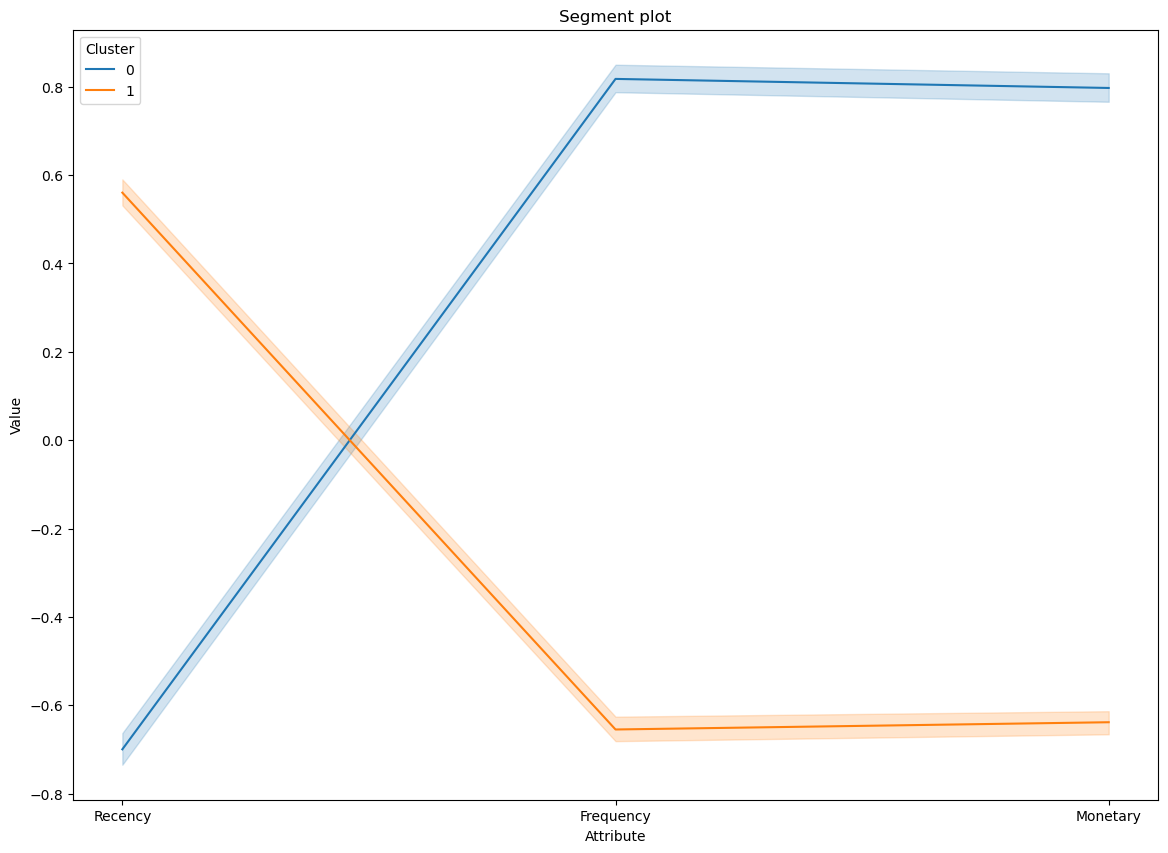

In [40]:
# Visualize segment characteristics to understand the clusters better

plt.figure(figsize = (14,10))
plt.title('Segment plot') 
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=df8_melt)

## 4. Relative feature importances w.r.t clusters

In [41]:
cluster_avg = df5_clus2.groupby(['Cluster']).mean()
cluster_avg

,Recency,Frequency,Monetary
Cluster,,,
0,29.826772,171.479265,3521.034437
1,139.396805,25.092896,427.075520


In [42]:
population_avg = df5.mean()
population_avg

Recency        90.673436
Frequency      90.187675
Monetary     1802.890585
dtype: float64

In [43]:
relative_imp = cluster_avg / population_avg - 1

In [44]:
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,-0.67,0.90,0.95
1,0.54,-0.72,-0.76


<AxesSubplot:title={'center':'Relative importance of attributes'}, ylabel='Cluster'>

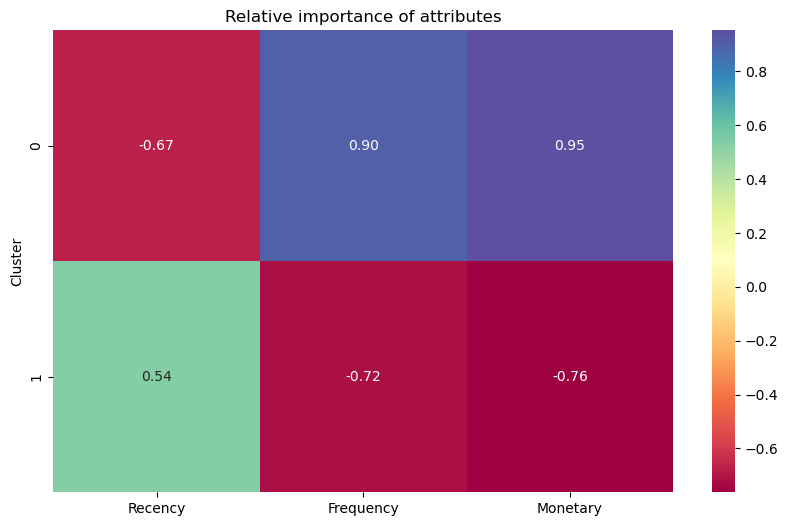

In [45]:
plt.figure(figsize=(10, 6))
plt.title('Relative importance of attributes') 
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Spectral')